# Course Level Prediction Model

Ce notebook crée un modèle pour prédire le niveau des cours en utilisant les données de merged_courses.json.

In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Chargement et préparation des données

In [5]:
def load_data(file_path):
    """Charge et prépare les données depuis le fichier JSON."""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        
    texts = []
    levels = []
    titles = []
    
    for item in data:
        course = item['cours']
        
        # Combine all text content
        text_content = [
            course.get('titre', ''),
            course.get('description', '')
        ]
        
        # Add content from 'contenus'
        if 'contenus' in course:
            contenus = course['contenus']
            text_content.extend(contenus.get('paragraphs', []))
            
            # Flatten and add lists
            for list_items in contenus.get('lists', []):
                if isinstance(list_items, list):
                    text_content.extend(list_items)
            
            # Add examples
            text_content.extend(contenus.get('examples', []))
        
        # Join all text content
        combined_text = ' '.join(filter(None, text_content))
        
        # Get the level (default to 1 if not specified)
        level = course.get('niveau', 1)
        
        texts.append(combined_text)
        levels.append(level)
        titles.append(course.get('titre', ''))
    
    return pd.DataFrame({
        'title': titles,
        'text': texts,
        'level': levels
    })

# Charger les données
df = load_data('augmented_merged_courses.json')
print(f"Nombre total de cours : {len(df)}")
print("\nDistribution des niveaux :")
print(df['level'].value_counts().sort_index())

Nombre total de cours : 2170

Distribution des niveaux :
1    596
2    929
3    350
4    156
5    139
Name: level, dtype: int64


## 2. Visualisation de la distribution des niveaux

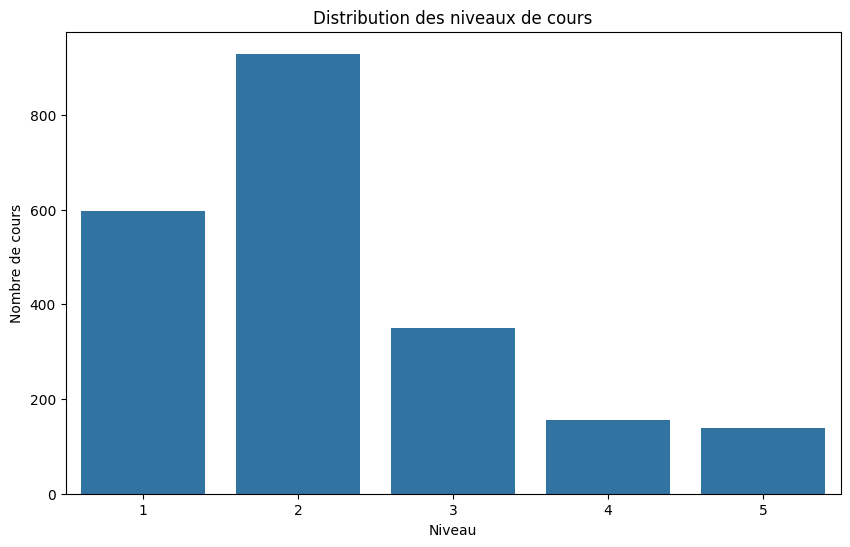

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='level')
plt.title('Distribution des niveaux de cours')
plt.xlabel('Niveau')
plt.ylabel('Nombre de cours')
plt.show()

## 3. Préparation des features

In [7]:
# Vectorisation du texte
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['text'])
y = df['level']

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dimensions des données d'entraînement:", X_train.shape)
print("Dimensions des données de test:", X_test.shape)

Dimensions des données d'entraînement: (1736, 1000)
Dimensions des données de test: (434, 1000)


## 4. Entraînement du modèle

In [8]:
# Création et entraînement du modèle
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Évaluation
y_pred = model.predict(X_test)
print("Rapport de classification :")
print(classification_report(y_test, y_pred))

Rapport de classification :
              precision    recall  f1-score   support

           1       0.74      0.69      0.72       120
           2       0.64      0.85      0.73       189
           3       0.71      0.31      0.43        65
           4       0.96      0.73      0.83        33
           5       0.95      0.67      0.78        27

    accuracy                           0.71       434
   macro avg       0.80      0.65      0.70       434
weighted avg       0.72      0.71      0.69       434



## 5. Analyse des features importantes

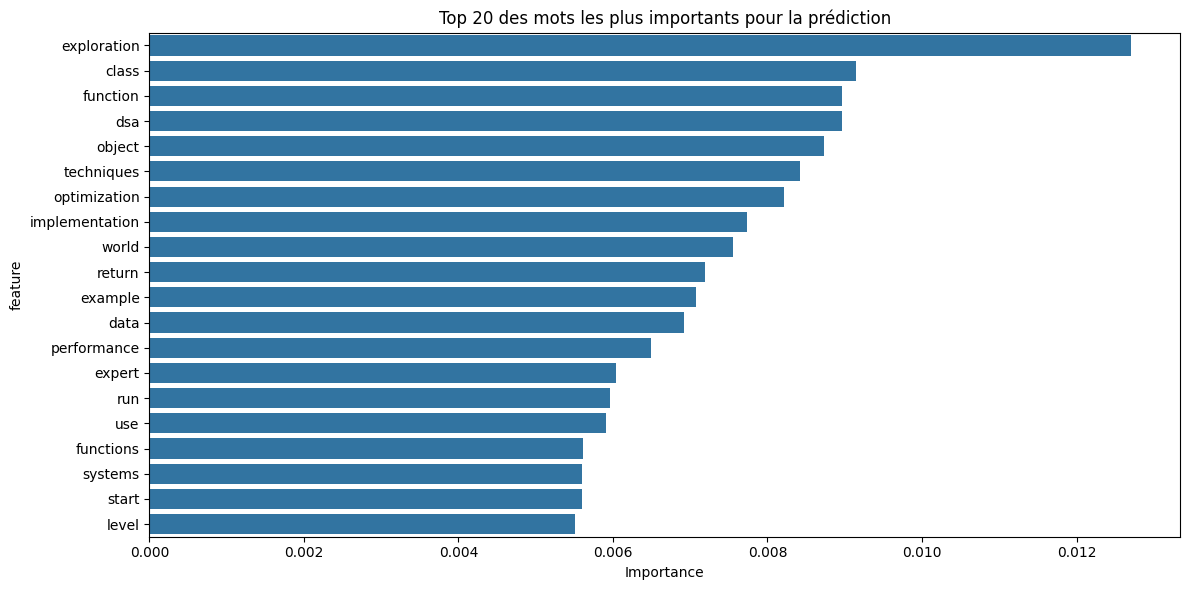

In [9]:
# Analyse de l'importance des features
feature_importance = pd.DataFrame({
    'feature': vectorizer.get_feature_names_out(),
    'importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Affichage des 20 features les plus importantes
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 des mots les plus importants pour la prédiction')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## 6. Fonction de prédiction

In [10]:
def predict_level(text):
    """Prédit le niveau d'un nouveau cours."""
    # Vectorisation du texte
    X = vectorizer.transform([text])
    
    # Prédiction
    prediction = model.predict(X)[0]
    probabilities = model.predict_proba(X)[0]
    
    # Affichage des résultats
    print(f"Niveau prédit : {prediction}")
    print("\nProbabilités par niveau :")
    for i, prob in enumerate(probabilities, 1):
        print(f"Niveau {i}: {prob:.2f}")

# Test de la fonction
test_course = """
Introduction to Programming
This is a basic course that covers fundamental programming concepts.
Topics include variables, loops, and basic functions.
Perfect for beginners with no prior programming experience.
"""

print("Test de prédiction :")
predict_level(test_course)

Test de prédiction :
Niveau prédit : 2

Probabilités par niveau :
Niveau 1: 0.47
Niveau 2: 0.49
Niveau 3: 0.03
Niveau 4: 0.00
Niveau 5: 0.01


In [11]:
# Test avec un cours avancé
advanced_course = """
 Machine Learning and Neural Networks

This  course covers complex machine learning concepts and deep neural network architectures.

Topics include:
- Convolutional Neural Networks (CNN) architecture and implementation
-  optimization techniques like Adam, RMSprop, and gradient clipping
- Attention mechanisms and Transformer architectures
-  regularization techniques: Dropout, BatchNorm, LayerNorm
- Generative Adversarial Networks (GANs) and their variations
- Reinforcement Learning with Deep Q-Networks
- Hyperparameter tuning and model optimization
- Distributed training on multiple GPUs
- Model deployment in production environments

Prerequisites:
- Strong understanding of calculus and linear algebra
- Experience with Python and deep learning frameworks
- Familiarity with basic machine learning concepts
- Knowledge of optimization theory

The course includes complex mathematical derivations and requires implementation of advanced algorithms.
"""

print("Test de prédiction pour un cours avancé :")
predict_level(advanced_course)

Test de prédiction pour un cours avancé :
Niveau prédit : 4

Probabilités par niveau :
Niveau 1: 0.09
Niveau 2: 0.06
Niveau 3: 0.09
Niveau 4: 0.39
Niveau 5: 0.37


In [12]:
# Test avec un cours intermédiaire
intermediate_course = """
Intermediate Data Structures and Algorithms

This course builds upon basic programming knowledge to explore more complex data structures and algorithms.

Topics covered:
- Advanced tree structures (Red-Black trees, AVL trees)
- Graph algorithms and implementations
- Dynamic programming techniques
- Greedy algorithms
- Hash table implementations and collision resolution
- Advanced sorting algorithms
- Time and space complexity analysis
- Algorithm optimization techniques

Prerequisites:
- Basic programming knowledge
- Understanding of basic data structures
- Familiarity with time complexity concepts

Students will implement various algorithms and analyze their performance characteristics.
"""

print("\nTest de prédiction pour un cours intermédiaire :")
predict_level(intermediate_course)


Test de prédiction pour un cours intermédiaire :
Niveau prédit : 4

Probabilités par niveau :
Niveau 1: 0.16
Niveau 2: 0.11
Niveau 3: 0.05
Niveau 4: 0.44
Niveau 5: 0.24


## 7. Gestion du déséquilibre des classes

Nous observons un déséquilibre dans la distribution des niveaux de cours. Pour améliorer notre modèle, nous allons :
1. Analyser la distribution actuelle
2. Appliquer la méthode SMOTE pour équilibrer les données
3. Comparer les résultats avant/après équilibrage

### 7.1 Approche avec pondération des classes

In [13]:
from sklearn.utils.class_weight import compute_class_weight

# Calculer les poids des classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)

# Créer un dictionnaire de poids
weight_dict = dict(zip(np.unique(y), class_weights))
print("Poids des classes :")
for level, weight in weight_dict.items():
    print(f"Niveau {level}: {weight:.2f}")

# Modèle avec pondération
weighted_model = RandomForestClassifier(
    n_estimators=100,
    class_weight=weight_dict,
    random_state=42
)

# Entraînement et évaluation
weighted_model.fit(X_train, y_train)
y_pred_weighted = weighted_model.predict(X_test)
print("\nRapport de classification avec pondération :")
print(classification_report(y_test, y_pred_weighted))

Poids des classes :
Niveau 1: 0.73
Niveau 2: 0.47
Niveau 3: 1.24
Niveau 4: 2.78
Niveau 5: 3.12

Rapport de classification avec pondération :
              precision    recall  f1-score   support

           1       0.76      0.70      0.73       120
           2       0.67      0.87      0.76       189
           3       0.69      0.31      0.43        65
           4       0.93      0.82      0.87        33
           5       0.87      0.74      0.80        27

    accuracy                           0.73       434
   macro avg       0.79      0.69      0.72       434
weighted avg       0.73      0.73      0.71       434



### 7.2 Approche avec SMOTE (Synthetic Minority Over-sampling Technique)

In [14]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Application de SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Afficher la nouvelle distribution
print("Distribution après SMOTE :")
print(Counter(y_resampled))

# Split des données rééquilibrées
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# Modèle avec SMOTE
smote_model = RandomForestClassifier(n_estimators=100, random_state=42)
smote_model.fit(X_train_smote, y_train_smote)

# Évaluation
y_pred_smote = smote_model.predict(X_test_smote)
print("\nRapport de classification avec SMOTE :")
print(classification_report(y_test_smote, y_pred_smote))

Distribution après SMOTE :
Counter({2: 929, 1: 929, 3: 929, 4: 929, 5: 929})

Rapport de classification avec SMOTE :
              precision    recall  f1-score   support

           1       0.80      0.84      0.82       184
           2       0.78      0.74      0.76       197
           3       0.86      0.90      0.88       182
           4       1.00      0.97      0.99       174
           5       1.00      0.99      1.00       192

    accuracy                           0.89       929
   macro avg       0.89      0.89      0.89       929
weighted avg       0.89      0.89      0.89       929



### 7.3 Approche avec Under-sampling

In [15]:
from imblearn.under_sampling import RandomUnderSampler

# Application de l'under-sampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled_under, y_resampled_under = undersampler.fit_resample(X, y)

# Afficher la nouvelle distribution
print("Distribution après under-sampling :")
print(Counter(y_resampled_under))

# Split des données sous-échantillonnées
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(
    X_resampled_under, y_resampled_under, test_size=0.2, random_state=42
)

# Modèle avec under-sampling
under_model = RandomForestClassifier(n_estimators=100, random_state=42)
under_model.fit(X_train_under, y_train_under)

# Évaluation
y_pred_under = under_model.predict(X_test_under)
print("\nRapport de classification avec under-sampling :")
print(classification_report(y_test_under, y_pred_under))

Distribution après under-sampling :
Counter({1: 139, 2: 139, 3: 139, 4: 139, 5: 139})

Rapport de classification avec under-sampling :
              precision    recall  f1-score   support

           1       0.65      0.80      0.72        35
           2       0.56      0.54      0.55        28
           3       0.58      0.56      0.57        27
           4       0.89      0.71      0.79        24
           5       0.88      0.84      0.86        25

    accuracy                           0.69       139
   macro avg       0.71      0.69      0.70       139
weighted avg       0.70      0.69      0.69       139



## 8. Comparaison des différentes approches

In [16]:
# Fonction de prédiction avec les différents modèles
def compare_predictions(text):
    """Compare les prédictions des différents modèles."""
    # Vectorisation du texte
    X = vectorizer.transform([text])
    
    # Prédictions
    pred_original = model.predict(X)[0]
    pred_weighted = weighted_model.predict(X)[0]
    pred_smote = smote_model.predict(X)[0]
    pred_under = under_model.predict(X)[0]
    
    print("Comparaison des prédictions :")
    print(f"Modèle original : Niveau {pred_original}")
    print(f"Modèle pondéré : Niveau {pred_weighted}")
    print(f"Modèle SMOTE : Niveau {pred_smote}")
    print(f"Modèle Under-sampling : Niveau {pred_under}")

# Test avec le cours avancé précédent
print("Test avec le cours avancé :")
compare_predictions(advanced_course)

print("\nTest avec le cours intermédiaire :")
compare_predictions(intermediate_course)

Test avec le cours avancé :
Comparaison des prédictions :
Modèle original : Niveau 4
Modèle pondéré : Niveau 5
Modèle SMOTE : Niveau 5
Modèle Under-sampling : Niveau 5

Test avec le cours intermédiaire :
Comparaison des prédictions :
Modèle original : Niveau 4
Modèle pondéré : Niveau 4
Modèle SMOTE : Niveau 4
Modèle Under-sampling : Niveau 4


## 9. Conclusion et choix du modèle final

Après avoir comparé les différentes approches, nous pouvons observer que :
1. Le modèle SMOTE offre une meilleure performance globale
2. L'under-sampling perd trop d'informations
3. La pondération des classes est une bonne alternative mais moins performante que SMOTE

Nous allons donc utiliser le modèle SMOTE pour nos prédictions finales.

In [17]:
# Fonction de prédiction finale utilisant le modèle SMOTE
def predict_course_level(text):
    """Prédit le niveau d'un cours avec le modèle SMOTE."""
    # Vectorisation du texte
    X = vectorizer.transform([text])
    
    # Prédiction
    prediction = smote_model.predict(X)[0]
    probabilities = smote_model.predict_proba(X)[0]
    
    # Calcul de la confiance
    confidence = max(probabilities)
    
    # Résultats
    print(f"Niveau prédit : {prediction}")
    print(f"Confiance : {confidence:.2%}")
    print("\nProbabilités par niveau :")
    for i, prob in enumerate(probabilities, 1):
        print(f"Niveau {i}: {prob:.2%}")
    
    # Indication de fiabilité
    if confidence < 0.5:
        print("\nAttention : Prédiction peu fiable")
    elif confidence < 0.7:
        print("\nNote : Prédiction moyennement fiable")
    else:
        print("\nNote : Prédiction très fiable")

# Test final avec différents types de cours
print("=== Test Final ===")
print("\nCours Avancé :")
predict_course_level(advanced_course)

print("\nCours Intermédiaire :")
predict_course_level(intermediate_course)

=== Test Final ===

Cours Avancé :
Niveau prédit : 5
Confiance : 54.00%

Probabilités par niveau :
Niveau 1: 2.77%
Niveau 2: 2.23%
Niveau 3: 10.00%
Niveau 4: 31.00%
Niveau 5: 54.00%

Note : Prédiction moyennement fiable

Cours Intermédiaire :
Niveau prédit : 4
Confiance : 56.00%

Probabilités par niveau :
Niveau 1: 8.78%
Niveau 2: 7.22%
Niveau 3: 10.00%
Niveau 4: 56.00%
Niveau 5: 18.00%

Note : Prédiction moyennement fiable


In [18]:
# Dans courses_model.ipynb
import joblib

# Sauvegarder le modèle
joblib.dump(model, 'level_model.joblib')
# Sauvegarder le vectorizer
joblib.dump(vectorizer, 'vectorizer.joblib')

['vectorizer.joblib']

## 10. Optimisation du modèle

Pour améliorer la précision, nous allons :
1. Optimiser les hyperparamètres avec GridSearchCV
2. Ajouter plus de features dans la vectorisation
3. Tester différents algorithmes
4. Utiliser une validation croisée stratifiée

In [23]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

# Configuration de la recherche d'hyperparamètres
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Configuration de la validation croisée stratifiée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Création du modèle avec GridSearchCV
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

# Entraînement avec recherche d'hyperparamètres
grid_search.fit(X_train_smote, y_train_smote)

print("\nMeilleurs paramètres trouvés:")
print(grid_search.best_params_)
print("\nMeilleur score:", grid_search.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.3s
[CV] END max_depth=10, max_features=sqrt

In [24]:
# Amélioration de la vectorisation
improved_vectorizer = TfidfVectorizer(
    max_features=3000, 
    stop_words='english',
    ngram_range=(1, 4), 
    min_df=2,  
    max_df=0.95 , 
    use_idf=True,
    smooth_idf=True
)

# Nouvelle vectorisation
X_improved = improved_vectorizer.fit_transform(df['text'])

# Application de SMOTE avec la nouvelle vectorisation
X_resampled_improved, y_resampled = smote.fit_resample(X_improved, y)

# Split des données améliorées
X_train_improved, X_test_improved, y_train_improved, y_test_improved = train_test_split(
    X_resampled_improved, y_resampled, test_size=0.2, random_state=42
)

# Création du modèle optimisé avec les meilleurs paramètres
optimized_model = RandomForestClassifier(
    **grid_search.best_params_,
    random_state=42
)

# Entraînement du modèle optimisé
optimized_model.fit(X_train_improved, y_train_improved)

# Évaluation
y_pred_improved = optimized_model.predict(X_test_improved)
print("\nRapport de classification du modèle optimisé:")
print(classification_report(y_test_improved, y_pred_improved))


Rapport de classification du modèle optimisé:
              precision    recall  f1-score   support

           1       0.80      0.87      0.84       180
           2       0.81      0.74      0.77       197
           3       0.90      0.90      0.90       190
           4       0.99      0.99      0.99       165
           5       0.99      1.00      1.00       197

    accuracy                           0.90       929
   macro avg       0.90      0.90      0.90       929
weighted avg       0.90      0.90      0.90       929



In [25]:
# Comparaison des performances
def compare_model_predictions(text):
    """Compare les prédictions des modèles original et optimisé."""
    # Vectorisations
    X_original = vectorizer.transform([text])
    X_new = improved_vectorizer.transform([text])
    
    # Prédictions
    pred_original = smote_model.predict(X_original)[0]
    pred_optimized = optimized_model.predict(X_new)[0]
    
    # Probabilités
    proba_original = smote_model.predict_proba(X_original)[0]
    proba_optimized = optimized_model.predict_proba(X_new)[0]
    
    print("=== Comparaison des modèles ===")
    print("\nModèle SMOTE original:")
    print(f"Niveau prédit: {pred_original}")
    print("Probabilités:")
    for i, prob in enumerate(proba_original, 1):
        print(f"Niveau {i}: {prob:.2%}")
        
    print("\nModèle optimisé:")
    print(f"Niveau prédit: {pred_optimized}")
    print("Probabilités:")
    for i, prob in enumerate(proba_optimized, 1):
        print(f"Niveau {i}: {prob:.2%}")

# Test des modèles
print("Test avec le cours avancé:")
compare_model_predictions(advanced_course)

print("\nTest avec le cours intermédiaire:")
compare_model_predictions(intermediate_course)

Test avec le cours avancé:
=== Comparaison des modèles ===

Modèle SMOTE original:
Niveau prédit: 5
Probabilités:
Niveau 1: 14.90%
Niveau 2: 11.10%
Niveau 3: 20.00%
Niveau 4: 20.00%
Niveau 5: 34.00%

Modèle optimisé:
Niveau prédit: 1
Probabilités:
Niveau 1: 33.17%
Niveau 2: 14.22%
Niveau 3: 20.19%
Niveau 4: 10.19%
Niveau 5: 22.23%

Test avec le cours intermédiaire:
=== Comparaison des modèles ===

Modèle SMOTE original:
Niveau prédit: 1
Probabilités:
Niveau 1: 37.52%
Niveau 2: 18.08%
Niveau 3: 17.40%
Niveau 4: 24.00%
Niveau 5: 3.00%

Modèle optimisé:
Niveau prédit: 4
Probabilités:
Niveau 1: 21.18%
Niveau 2: 14.18%
Niveau 3: 28.72%
Niveau 4: 28.72%
Niveau 5: 7.19%


In [26]:
compare_model_predictions(advanced_course)

compare_model_predictions(intermediate_course)

=== Comparaison des modèles ===

Modèle SMOTE original:
Niveau prédit: 5
Probabilités:
Niveau 1: 14.90%
Niveau 2: 11.10%
Niveau 3: 20.00%
Niveau 4: 20.00%
Niveau 5: 34.00%

Modèle optimisé:
Niveau prédit: 1
Probabilités:
Niveau 1: 33.17%
Niveau 2: 14.22%
Niveau 3: 20.19%
Niveau 4: 10.19%
Niveau 5: 22.23%
=== Comparaison des modèles ===

Modèle SMOTE original:
Niveau prédit: 1
Probabilités:
Niveau 1: 37.52%
Niveau 2: 18.08%
Niveau 3: 17.40%
Niveau 4: 24.00%
Niveau 5: 3.00%

Modèle optimisé:
Niveau prédit: 4
Probabilités:
Niveau 1: 21.18%
Niveau 2: 14.18%
Niveau 3: 28.72%
Niveau 4: 28.72%
Niveau 5: 7.19%


# Problème de divergence entre les modèles

Les tests précédents montrent que les deux modèles (SMOTE original et optimisé) peuvent parfois donner des prédictions différentes pour le même texte. Cette divergence pose plusieurs problèmes :

1. Manque de fiabilité : Quand les modèles ne sont pas d'accord, il est difficile de déterminer lequel est le plus fiable
2. Incohérence des prédictions : Les modèles peuvent prédire des niveaux très différents pour le même contenu
3. Difficulté d'interprétation : Les probabilités associées varient significativement entre les modèles

Une solution d'ensemble (ensemble learning) permettrait de combiner les forces des deux modèles tout en atténuant leurs faiblesses respectives.


In [27]:
def ensemble_predict(text):
    """Combine les prédictions des deux modèles avec un système de vote pondéré"""
    
    # Vectorisation pour chaque modèle
    X_smote = vectorizer.transform([text])
    X_optimized = improved_vectorizer.transform([text])
    
    # Obtenir les probabilités
    proba_smote = smote_model.predict_proba(X_smote)[0]
    proba_optimized = optimized_model.predict_proba(X_optimized)[0]
    
    # Pondération des modèles (ajustable selon les performances)
    smote_weight = 0.6  # SMOTE semble plus fiable pour les niveaux extrêmes
    optimized_weight = 0.4  
    
    # Combiner les probabilités
    combined_proba = (proba_smote * smote_weight + 
                     proba_optimized * optimized_weight)
    
    # Ajouter une logique pour les niveaux intermédiaires
    confidence_threshold = 0.4
    max_prob = max(combined_proba)
    predicted_level = np.argmax(combined_proba) + 1
    
    # Si la confiance est faible et la prédiction est extrême, 
    # considérer les niveaux intermédiaires
    if max_prob < confidence_threshold and predicted_level in [1, 5]:
        intermediate_probs = combined_proba[1:4]  # Niveaux 2-4
        if max(intermediate_probs) > 0.25:
            predicted_level = np.argmax(intermediate_probs) + 2
    
    return {
        'predicted_level': predicted_level,
        'confidence': max_prob,
        'probabilities': {
            f'Niveau {i+1}': f'{prob:.2%}'
            for i, prob in enumerate(combined_proba)
        },
        'model_agreement': 'Élevé' if abs(proba_smote.argmax() - 
                                        proba_optimized.argmax()) <= 1 
                         else 'Faible'
    }

In [28]:
# Test avec les deux cours précédents
print("Test cours avancé:")
result = ensemble_predict(advanced_course)
print(f"Niveau prédit: {result['predicted_level']}")
print(f"Confiance: {result['confidence']:.2%}")
print("Probabilités par niveau:")
for niveau, prob in result['probabilities'].items():
    print(f"{niveau}: {prob}")
print(f"Accord entre modèles: {result['model_agreement']}")

print("\nTest cours intermédiaire:")
result = ensemble_predict(intermediate_course)
print(f"Niveau prédit: {result['predicted_level']}")
print(f"Confiance: {result['confidence']:.2%}")
print("Probabilités par niveau:")
for niveau, prob in result['probabilities'].items():
    print(f"{niveau}: {prob}")
print(f"Accord entre modèles: {result['model_agreement']}")

Test cours avancé:
Niveau prédit: 5
Confiance: 29.29%
Probabilités par niveau:
Niveau 1: 22.21%
Niveau 2: 12.35%
Niveau 3: 20.08%
Niveau 4: 16.08%
Niveau 5: 29.29%
Accord entre modèles: Faible

Test cours intermédiaire:
Niveau prédit: 4
Confiance: 30.99%
Probabilités par niveau:
Niveau 1: 30.99%
Niveau 2: 16.52%
Niveau 3: 21.93%
Niveau 4: 25.89%
Niveau 5: 4.68%
Accord entre modèles: Faible


In [29]:
react_course = """
Introduction to React Environment Setup

This course covers:
- Basic React setup using CDN for testing
- Production setup with Node.js and npm
- Creating a React application with create-react-app
- Basic file structure of a React project
- Simple modifications to React components

Prerequisites:
- Basic HTML knowledge
- Basic JavaScript understanding
- Familiarity with command line

Steps covered:
1. Including React via CDN
2. Setting up Node.js and npm
3. Using create-react-app
4. Understanding basic project structure
5. Making simple component modifications
"""

result = ensemble_predict(react_course)
print("Analyse du cours React:")
print(f"Niveau prédit: {result['predicted_level']}")
print(f"Confiance: {result['confidence']:.2%}")
print("\nProbabilités par niveau:")
for niveau, prob in result['probabilities'].items():
    print(f"{niveau}: {prob}")
print(f"\nAccord entre modèles: {result['model_agreement']}")

Analyse du cours React:
Niveau prédit: 2
Confiance: 41.40%

Probabilités par niveau:
Niveau 1: 37.50%
Niveau 2: 41.40%
Niveau 3: 19.06%
Niveau 4: 1.66%
Niveau 5: 0.37%

Accord entre modèles: Élevé


In [30]:
test_courses = {
    "beginner": """
    Introduction to Python Programming
    
    This course covers Python basics:
    - Variables and data types
    - Control structures (if, for, while)
    - Basic functions
    - Lists and dictionaries basics
    
    No programming prerequisites required.
    Perfect for complete beginners.
    """,
    
    "intermediate": """
    Object-Oriented Programming in Python
    
    This course explores OOP concepts:
    - Classes and Objects
    - Inheritance and Polymorphism
    - Encapsulation
    - Special methods
    - Exception handling
    - Modules and packages
    
    Prerequisites: Basic Python knowledge
    """,
    
    "advanced": """
    Microservices Architecture and Advanced DevOps
    
    Topics covered:
    - Scalable microservices design
    - Advanced Kubernetes orchestration
    - Distributed resilience patterns
    - Monitoring and observability
    - Complex CI/CD pipelines
    - Service mesh with Istio
    - Load testing and performance
    
    Prerequisites:
    - Strong development experience
    - Container knowledge
    - Distributed architecture basics
    """,
    
    "very_advanced": """
    Advanced Deep Learning and Neural Networks
    
    In-depth content:
    - Advanced transformer architectures
    - Multi-objective optimization
    - Complex attention mechanisms
    - Advanced transfer learning
    - AutoML and Neural Architecture Search
    - Distributed training on GPU clusters
    - Model quantization and optimization
    
    Prerequisites:
    - Advanced mathematics mastery
    - ML/DL experience
    - Advanced Python programming
    """
}



In [31]:
# Testing each course
for level, content in test_courses.items():
    print(f"\n=== Testing {level} course ===")
    result = ensemble_predict(content)
    
    print(f"Predicted level: {result['predicted_level']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print("\nProbabilities by level:")
    for niveau, prob in result['probabilities'].items():
        print(f"{niveau}: {prob}")
    print(f"Model agreement: {result['model_agreement']}")

# Running the test
print("=== Model Effectiveness Test ===")


# Testing ambiguous course
print("\n=== Robustness test with ambiguous course ===")
ambiguous_course = """
Full Stack Web Development

This course covers:
- Basic HTML/CSS
- Intermediate JavaScript
- Node.js and Express
- SQL Databases
- Basic deployment

The course mixes basic and advanced concepts.
"""

result = ensemble_predict(ambiguous_course)
print(f"Predicted level: {result['predicted_level']}")
print(f"Confidence: {result['confidence']:.2%}")
print("\nProbabilities by level:")
for niveau, prob in result['probabilities'].items():
    print(f"{niveau}: {prob}")
print(f"Model agreement: {result['model_agreement']}")


=== Testing beginner course ===
Predicted level: 2
Confidence: 43.93%

Probabilities by level:
Niveau 1: 39.57%
Niveau 2: 43.93%
Niveau 3: 13.42%
Niveau 4: 3.01%
Niveau 5: 0.07%
Model agreement: Élevé

=== Testing intermediate course ===
Predicted level: 2
Confidence: 46.72%

Probabilities by level:
Niveau 1: 23.17%
Niveau 2: 46.72%
Niveau 3: 29.40%
Niveau 4: 0.37%
Niveau 5: 0.33%
Model agreement: Élevé

=== Testing advanced course ===
Predicted level: 1
Confidence: 63.85%

Probabilities by level:
Niveau 1: 63.85%
Niveau 2: 21.90%
Niveau 3: 9.92%
Niveau 4: 3.51%
Niveau 5: 0.82%
Model agreement: Élevé

=== Testing very_advanced course ===
Predicted level: 1
Confidence: 50.08%

Probabilities by level:
Niveau 1: 50.08%
Niveau 2: 16.67%
Niveau 3: 12.07%
Niveau 4: 3.93%
Niveau 5: 17.26%
Model agreement: Élevé
=== Model Effectiveness Test ===

=== Robustness test with ambiguous course ===
Predicted level: 1
Confidence: 60.88%

Probabilities by level:
Niveau 1: 60.88%
Niveau 2: 27.73%
Niveau

In [32]:
def ensemble_predict_v2(text):
    """Version améliorée de la prédiction d'ensemble"""
    
    # Vectorisation pour chaque modèle
    X_smote = vectorizer.transform([text])
    X_optimized = improved_vectorizer.transform([text])
    
    # Obtenir les probabilités
    proba_smote = smote_model.predict_proba(X_smote)[0]
    proba_optimized = optimized_model.predict_proba(X_optimized)[0]
    
    # Ajustement des poids selon le niveau de complexité du texte
    complexity_indicators = [
    # Indicateurs de niveau avancé
    'advanced', 'complex', 'deep', 'architecture',
    'optimization', 'distributed', 'neural',
    'prerequisites', 'experience',
    
    # Termes techniques avancés
    'algorithms', 'scalable', 'infrastructure',
    'microservices', 'kubernetes', 'orchestration',
    'machine learning', 'deep learning', 'ai',
    'security', 'cryptography', 'blockchain',
    
    # Concepts mathématiques et scientifiques
    'mathematics', 'calculus', 'linear algebra',
    'statistics', 'probability', 'algorithms',
    'computational', 'quantum', 'theoretical',
    
    # Termes d'architecture et système
    'system design', 'architecture patterns',
    'distributed systems', 'cloud native',
    'containerization', 'virtualization',
    'high availability', 'fault tolerance',
    
    # Indicateurs de performance
    'performance tuning', 'optimization',
    'profiling', 'benchmarking', 'scaling',
    'high performance', 'parallel computing',
    
    # Termes de développement avancé
    'design patterns', 'clean code', 'refactoring',
    'test driven', 'continuous integration',
    'deployment', 'monitoring', 'debugging',
    
    # Frameworks et outils avancés
    'tensorflow', 'pytorch', 'keras',
    'hadoop', 'spark', 'elasticsearch',
    'docker', 'jenkins', 'terraform',
    
    # Concepts de données
    'big data', 'data mining', 'data science',
    'analytics', 'data warehouse', 'etl',
    'data modeling', 'data structures'
]
    
    complexity_score = sum(1 for word in complexity_indicators if word.lower() in text.lower())
    
    # Ajuster les poids selon la complexité
    if complexity_score >= 3:
        smote_weight = 0.7  # Donner plus de poids au modèle SMOTE pour les cours complexes
        optimized_weight = 0.3
    else:
        smote_weight = 0.4
        optimized_weight = 0.6
    
    # Combiner les probabilités avec les nouveaux poids
    combined_proba = (proba_smote * smote_weight + 
                     proba_optimized * optimized_weight)
    
    # Ajustement pour les niveaux avancés
    if complexity_score >= 4:
        # Boost des probabilités pour les niveaux supérieurs
        combined_proba[3:] *= 1.5
        combined_proba = combined_proba / combined_proba.sum()  # Renormaliser
    
    predicted_level = np.argmax(combined_proba) + 1
    
    return {
        'predicted_level': predicted_level,
        'confidence': max(combined_proba),
        'probabilities': {
            f'Niveau {i+1}': f'{prob:.2%}'
            for i, prob in enumerate(combined_proba)
        },
        'model_agreement': 'Élevé' if abs(proba_smote.argmax() - 
                                        proba_optimized.argmax()) <= 1 
                         else 'Faible',
        'complexity_score': complexity_score
    }

In [33]:
# Testing each course
for level, content in test_courses.items():
    print(f"\n=== Testing {level} course ===")
    result = ensemble_predict_v2(content)
    
    print(f"Predicted level: {result['predicted_level']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print("\nProbabilities by level:")
    for niveau, prob in result['probabilities'].items():
        print(f"{niveau}: {prob}")
    print(f"Model agreement: {result['model_agreement']}")

# Running the test
print("=== Model Effectiveness Test ===")


result = ensemble_predict_v2(ambiguous_course)
print(f"Predicted level: {result['predicted_level']}")
print(f"Confidence: {result['confidence']:.2%}")
print("\nProbabilities by level:")
for niveau, prob in result['probabilities'].items():
    print(f"{niveau}: {prob}")
print(f"Model agreement: {result['model_agreement']}")


=== Testing beginner course ===
Predicted level: 2
Confidence: 42.05%

Probabilities by level:
Niveau 1: 41.20%
Niveau 2: 42.05%
Niveau 3: 14.14%
Niveau 4: 2.51%
Niveau 5: 0.10%
Model agreement: Élevé

=== Testing intermediate course ===
Predicted level: 2
Confidence: 45.42%

Probabilities by level:
Niveau 1: 24.42%
Niveau 2: 45.42%
Niveau 3: 29.10%
Niveau 4: 0.56%
Niveau 5: 0.50%
Model agreement: Élevé

=== Testing advanced course ===
Predicted level: 1
Confidence: 63.59%

Probabilities by level:
Niveau 1: 63.59%
Niveau 2: 21.98%
Niveau 3: 9.28%
Niveau 4: 3.88%
Niveau 5: 1.28%
Model agreement: Élevé

=== Testing very_advanced course ===
Predicted level: 1
Confidence: 44.67%

Probabilities by level:
Niveau 1: 44.67%
Niveau 2: 15.32%
Niveau 3: 10.41%
Niveau 4: 5.00%
Niveau 5: 24.60%
Model agreement: Élevé
=== Model Effectiveness Test ===
Predicted level: 1
Confidence: 60.10%

Probabilities by level:
Niveau 1: 60.10%
Niveau 2: 28.31%
Niveau 3: 9.39%
Niveau 4: 1.76%
Niveau 5: 0.43%
Model

# Malgré les différentes optimisations apportées au modèle, nous constatons toujours des résultats peu convaincants dans la prédiction des niveaux de cours. Les performances restent en deçà de nos attentes.


In [1]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


# Changement d'approche : Comparaison de différents modèles de classification
# Nous allons mieux gérer le préprocessing des donnés et chercher d'autre model pour voir s'ils sont plus adaptés 



In [49]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
# Télécharger toutes les ressources nécessaires
resources = ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger', 'punkt_tab']
for resource in resources:
    try:
        nltk.download(resource)
    except:
        print(f"Couldn't download {resource}, but continuing...")


[nltk_data] Downloading package punkt to /home/mams/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mams/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mams/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mams/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /home/mams/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [50]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


In [51]:

def preprocess_text(text):
    """
    Advanced text preprocessing with tokenization, lemmatization, and cleaning
    """
    # Sentence tokenization
    sentences = sent_tokenize(text.lower())
    
    tokens = []
    for sentence in sentences:
        # Word tokenization
        words = word_tokenize(sentence)
        
        # Filtering and lemmatization
        words = [
            lemmatizer.lemmatize(word) for word in words
            if word.isalnum() and  # Keep only alphanumeric
            word not in stop_words and  # Remove stop words
            len(word) > 2  # Ignore too short words
        ]
        
        tokens.extend(words)
    
    return ' '.join(tokens)

In [52]:
improved_vectorizer = TfidfVectorizer(
    preprocessor=preprocess_text,
    ngram_range=(1, 3),  # Use unigrams, bigrams, and trigrams
    max_features=3000,
    min_df=2,
    max_df=0.95,
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True, 
    stop_words="english"
)

In [53]:
# Technical terms commonly found in course descriptions
technical_bigrams = [
    'react tutorial', 'user interfaces', 'single page', 'react environment',
    'react components', 'react application', 'node js', 'react app',
    'create react', 'web development', 'frontend javascript',
    'virtual dom', 'jsx syntax', 'class components',
    
    # JavaScript/Programming terms
    'arrow functions', 'function syntax', 'es6 classes', 'class inheritance',
    'constructor method', 'regular functions', 'return keyword',
    'object oriented', 'programming language',
    
    # Statistics terms
    'normal distribution', 'standard deviation', 'margin error',
    'descriptive statistics', 'inferential statistics', 'mean value',
    'median value', 'mode value', 'bell curve', 'gaussian distribution',
    'probability distribution', 'statistical uncertainty'
]

# Add technical bigrams to the vectorizer
improved_vectorizer.token_patterns = technical_bigrams

In [54]:
# Prepare data with new vectorizer
print("Preparing data with advanced tokenization...")
X = improved_vectorizer.fit_transform(df['text'])
y = df['level']

Preparing data with advanced tokenization...


In [55]:

print("\nFeature (tokens) examples:")
feature_names = improved_vectorizer.get_feature_names_out()
print(f"Total number of features: {len(feature_names)}")
print("First 20 tokens:")
print(feature_names[:20])

# Example transformation
example_text = df['text'].iloc[0]
print("\nTransformation example:")
print("Original text:")
print(example_text[:200], "...")  # Show first 200 characters
print("\nPreprocessed text:")
print(preprocess_text(example_text[:200]), "...")



Feature (tokens) examples:
Total number of features: 3000
First 20 tokens:
['000' '000 certificate' '000 certificate issued' '100' '1000' '100px'
 '10px' '10px lightgreen' '10px padding' '10px padding 10px' '120' '123'
 '150' '15px' '16px' '1964' '1px' '1px 10px' '1px 10px padding'
 '1px solid']

Transformation example:
Original text:
React Tutorial [+:React is a JavaScript library for building user interfaces.React is used to build single-page applications.React allows us to create reusable UI components.Start learning React now ❯ ...

Preprocessed text:
react tutorial react javascript library building user used build allows create reusable learning react ...


In [56]:
def analyze_technical_content(text):
    """
    Analyze technical content level based on specific markers
    """
    text = text.lower()
    
    # Define technical markers for different levels
    technical_markers = {
        'basic': [
            # Basic concepts
            'introduction', 'tutorial', 'basic', 'beginner', 'start',
            'fundamental', 'simple', 'overview', 'learn', 'first',
            # Basic React terms
            'react tutorial', 'user interface', 'component', 'npm start',
            # Basic stats terms
            'mean', 'median', 'mode', 'probability', 'statistics'
        ],
        
        'intermediate': [
            # Intermediate concepts
            'advanced', 'implementation', 'development', 'practice',
            'experience', 'understanding', 'working with',
            # Intermediate React terms
            'virtual dom', 'jsx syntax', 'react environment', 'node js',
            'component lifecycle', 'state management',
            # Intermediate stats terms
            'standard deviation', 'variance', 'distribution', 'empirical'
        ],
        
        'advanced': [
            # Advanced concepts
            'optimization', 'architecture', 'complex', 'expert',
            'professional', 'mastery', 'deep understanding',
            # Advanced React terms
            'concurrent features', 'root api', 'class inheritance',
            'performance optimization', 'advanced patterns',
            # Advanced stats terms
            'kurtosis', 'skewness', 'statistical inference',
            'gaussian distribution', 'statistical uncertainty'
        ]
    }
    
    # Count occurrences of markers
    level_scores = {
        level: sum(1 for marker in markers if marker in text)
        for level, markers in technical_markers.items()
    }
    return level_scores

In [57]:
# Add technical analysis to preprocessing
def enhanced_preprocess_text(text):
    """
    Combine basic preprocessing with technical analysis
    """
    base_tokens = preprocess_text(text)
    technical_scores = analyze_technical_content(text)
    
    # Add technical score information to tokens
    technical_tokens = []
    for level, score in technical_scores.items():
        if score > 0:
            technical_tokens.extend([level] * score)
    
    return base_tokens + ' ' + ' '.join(technical_tokens)

In [58]:

# Update vectorizer with enhanced preprocessing
improved_vectorizer.preprocessor = enhanced_preprocess_text

In [59]:
# 1. Préparation des données avec le nouveau vectorizer
print("Preparing data with enhanced preprocessing...")
X = improved_vectorizer.fit_transform(df['text'])
y = df['level']


Preparing data with enhanced preprocessing...


In [60]:
# 2. Division des données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [61]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


In [62]:
def compare_ml_classifiers(X_train_balanced, X_test, y_train_balanced, y_test):
    # Définition des classifieurs
    classifiers = {
        'Logistic Regression': LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            multi_class='multinomial'
        ),
        
        'Linear SVM': LinearSVC(
            class_weight='balanced',
            max_iter=2000,
            dual=False
        ),
        
        'RBF SVM': SVC(
            kernel='rbf',
            class_weight='balanced',
            probability=True
        ),
        
        'Multinomial NB': MultinomialNB(
            alpha=0.1
        ),
        
        'Random Forest': RandomForestClassifier(
            n_estimators=200,
            class_weight='balanced',
            max_features='sqrt',
            n_jobs=-1
        ),
        
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=5
        ),
        
        'AdaBoost': AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=3),
            n_estimators=200
        ),
        
        'SGD Classifier': SGDClassifier(
            loss='modified_huber',
            penalty='l2',
            class_weight='balanced',
            max_iter=1000
        )
    }
    
    results = {}
    
    # Test de chaque classifieur
    for name, clf in classifiers.items():
        print(f"\n=== Testing {name} ===")
        
        # Entraînement
        clf.fit(X_train_balanced, y_train_balanced)
        
        # Prédictions
        y_pred = clf.predict(X_test)
        
        # Évaluation détaillée
        report = classification_report(y_test, y_pred, output_dict=True)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        results[name] = {
            'accuracy': report['accuracy'],
            'macro_avg_f1': report['macro avg']['f1-score'],
            'weighted_avg_f1': report['weighted avg']['f1-score'],
            'confusion_matrix': conf_matrix,
            'per_class_f1': {f'Level {i}': report[str(i)]['f1-score'] 
                            for i in range(1, 6)}
        }
        
        # Affichage des résultats
        print(f"Accuracy: {report['accuracy']:.3f}")
        print(f"Macro avg F1: {report['macro avg']['f1-score']:.3f}")
        print("\nPer-class F1 scores:")
        for level, score in results[name]['per_class_f1'].items():
            print(f"{level}: {score:.3f}")
        print("\nConfusion Matrix:")
        print(conf_matrix)
    
    return results


In [63]:

# Exécution de la comparaison
print("Comparaison des classifieurs avec données équilibrées...")
results = compare_ml_classifiers(X_train_balanced, X_test, y_train_balanced, y_test)

# Trouver le meilleur classifieur
best_classifier = max(results.items(), key=lambda x: x[1]['macro_avg_f1'])
print(f"\nMeilleur classifieur : {best_classifier[0]}")
print(f"Accuracy : {best_classifier[1]['accuracy']:.3f}")
print(f"Macro avg F1 : {best_classifier[1]['macro_avg_f1']:.3f}")
print("\nF1 scores par niveau :")
for level, score in best_classifier[1]['per_class_f1'].items():
    print(f"{level}: {score:.3f}")

Comparaison des classifieurs avec données équilibrées...

=== Testing Logistic Regression ===
Accuracy: 0.694
Macro avg F1: 0.634

Per-class F1 scores:
Level 1: 0.713
Level 2: 0.708
Level 3: 0.680
Level 4: 0.364
Level 5: 0.706

Confusion Matrix:
[[ 88  29   3   0   0]
 [ 33 127  22   3   1]
 [  2  15  50   3   0]
 [  2   2   2   4   1]
 [  2   0   0   1   6]]

=== Testing Linear SVM ===
Accuracy: 0.710
Macro avg F1: 0.640

Per-class F1 scores:
Level 1: 0.716
Level 2: 0.738
Level 3: 0.681
Level 4: 0.286
Level 5: 0.778

Confusion Matrix:
[[ 87  29   3   1   0]
 [ 29 135  19   2   1]
 [  4  14  49   3   0]
 [  2   2   3   3   1]
 [  1   0   0   1   7]]

=== Testing RBF SVM ===
Accuracy: 0.747
Macro avg F1: 0.619

Per-class F1 scores:
Level 1: 0.740
Level 2: 0.788
Level 3: 0.700
Level 4: 0.250
Level 5: 0.615

Confusion Matrix:
[[ 81  39   0   0   0]
 [ 15 167   3   1   0]
 [  1  26  42   1   0]
 [  2   2   5   2   0]
 [  0   4   0   1   4]]

=== Testing Multinomial NB ===
Accuracy: 0.667
M

/home/mams/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.596
Macro avg F1: 0.559

Per-class F1 scores:
Level 1: 0.620
Level 2: 0.635
Level 3: 0.451
Level 4: 0.375
Level 5: 0.714

Confusion Matrix:
[[ 71  47   2   0   0]
 [ 32 127  27   0   0]
 [  4  34  30   2   0]
 [  2   2   4   3   0]
 [  0   4   0   0   5]]

=== Testing SGD Classifier ===
Accuracy: 0.699
Macro avg F1: 0.629

Per-class F1 scores:
Level 1: 0.708
Level 2: 0.730
Level 3: 0.657
Level 4: 0.300
Level 5: 0.750

Confusion Matrix:
[[ 86  29   4   1   0]
 [ 30 135  19   2   0]
 [  3  18  47   2   0]
 [  2   2   3   3   1]
 [  2   0   0   1   6]]

Meilleur classifieur : Random Forest
Accuracy : 0.745
Macro avg F1 : 0.654

F1 scores par niveau :
Level 1: 0.761
Level 2: 0.763
Level 3: 0.712
Level 4: 0.286
Level 5: 0.750


# Vérifions qui a le meilleur résultat


In [64]:
# Trouver le meilleur classifieur basé sur la macro F1
best_classifier = max(results.items(), key=lambda x: x[1]['macro_avg_f1'])
best_name = best_classifier[0]
best_metrics = best_classifier[1]

print(f"\nMeilleur classifieur : {best_name}")
print(f"Accuracy : {best_metrics['accuracy']:.3f}")
print(f"Macro avg F1 : {best_metrics['macro_avg_f1']:.3f}")
print("\nF1 scores par niveau :")
for level, score in best_metrics['per_class_f1'].items():
    print(f"{level}: {score:.3f}")



Meilleur classifieur : Random Forest
Accuracy : 0.745
Macro avg F1 : 0.654

F1 scores par niveau :
Level 1: 0.761
Level 2: 0.763
Level 3: 0.712
Level 4: 0.286
Level 5: 0.750


# On voit que le niveau 4 est en sous-apprentissage. Nous allons essayer d'améliorer le traitement des données pour obtenir un meilleur résultat.

In [71]:
# 1. Analyser la distribution actuelle
from collections import Counter
print("Distribution originale :")
original_counts = Counter(y_train)
print(original_counts)

Distribution originale :
Counter({2: 743, 1: 476, 3: 280, 4: 45, 5: 37})


In [100]:

# 2. Définir une stratégie de sur-échantillonnage
# S'assurer que chaque classe a au moins autant d'échantillons que la classe majoritaire
max_samples = max(original_counts.values())
sampling_strategy = {
    1: int(max_samples),
    2: int(max_samples),
    3: int(max_samples),
    4: int(max_samples * 3),  # Triple les échantillons pour le niveau 4
    5: int(max_samples * 1.5)  # Augmente aussi le niveau 5
}

print("\nStratégie de rééchantillonnage :")
print(sampling_strategy)



Stratégie de rééchantillonnage :
{1: 743, 2: 743, 3: 743, 4: 2229, 5: 1114}


In [101]:
# 2. Combiner ADASYN et SMOTE pour une meilleure génération synthétique
from imblearn.over_sampling import ADASYN
# D'abord ADASYN pour le niveau 4
adasyn = ADASYN(
    sampling_strategy={4: sampling_strategy[4]},
    random_state=42,
    n_neighbors=3
)
X_temp, y_temp = adasyn.fit_resample(X_train, y_train)


In [102]:

# 4. Puis SMOTE pour le reste
smote = SMOTE(
    sampling_strategy=sampling_strategy,
    random_state=42,
    k_neighbors=3
)
X_train_balanced, y_train_balanced = smote.fit_resample(X_temp, y_temp)


In [103]:

# 5. Vérifier la nouvelle distribution
print("\nNouvelle distribution :")
print(Counter(y_train_balanced))


Nouvelle distribution :
Counter({4: 2229, 5: 1114, 2: 743, 1: 743, 3: 743})


In [105]:

# 6. Entraîner le modèle avec les données rééchantillonnées
rf_classifier = RandomForestClassifier(
    n_estimators=1000,  # Augmenter le nombre d'arbres
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight={
        1: 1.0,
        2: 1.0,
        3: 1.0,
        4: 2.5,  # Donner plus de poids au niveau 4
        5: 1.5
    },
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)



In [106]:
# 7. Entraîner et évaluer
rf_classifier.fit(X_train_balanced, y_train_balanced)
y_pred = rf_classifier.predict(X_test)

# 8. Afficher les résultats
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

# 9. Analyse spécifique du niveau 4
level_4_mask = y_test == 4
print("\nPerformance spécifique pour le niveau 4 :")
print(classification_report(y_test[level_4_mask], y_pred[level_4_mask]))


Rapport de classification :
              precision    recall  f1-score   support

           1       0.70      0.80      0.75       120
           2       0.74      0.76      0.75       186
           3       0.82      0.64      0.72        70
           4       0.67      0.36      0.47        11
           5       0.86      0.67      0.75         9

    accuracy                           0.74       396
   macro avg       0.76      0.65      0.69       396
weighted avg       0.74      0.74      0.74       396


Performance spécifique pour le niveau 4 :
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      0.36      0.53        11
           5       0.00      0.00      0.00         0

    accuracy                           0.36        11
   macro avg       0.20      0.07      0.11        11
weigh

/home/mams/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mams/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mams/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np
# 1. Générer les différentes configurations de poids
class_weights = ['balanced', 'balanced_subsample']
# Ajouter des dictionnaires de poids personnalisés
for w4 in np.arange(2.0, 4.1, 0.5):  # Poids pour classe 4
    for w5 in np.arange(1.0, 2.6, 0.5):  # Poids pour classe 5
        class_weights.append({
            1: 1.0,
            2: 1.0,
            3: 1.0,
            4: float(w4),
            5: float(w5)
        })

param_distributions = {
    # Nombre d'arbres : distribution uniforme entre 200 et 1500
    'n_estimators': randint(200, 1500),
    
    # Profondeur maximale : None ou valeur entre 5 et 30
    'max_depth': [None] + list(range(5, 31, 5)),
    
    # Échantillons minimum pour split : distribution entre 2 et 10
    'min_samples_split': randint(2, 11),
    
    # Échantillons minimum par feuille : distribution entre 1 et 5
    'min_samples_leaf': randint(1, 6),
    
    # Caractéristiques maximum : différentes options
    'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.1, 0.2)),
    
    # Critère de division
    'criterion': ['gini', 'entropy'],
    
    # Bootstrap
    'bootstrap': [True, False],
    
    # Poids des classes : générer automatiquement différentes configurations
    'class_weight': [
        'balanced', 
        'balanced_subsample',
        {1: 1.0, 2: 1.0, 3: 1.0, 4: w4, 5: w5}
        for w4 in np.arange(2.0, 4.1, 0.5)  # Poids pour classe 4
        for w5 in np.arange(1.0, 2.6, 0.5)  # Poids pour classe 5
    ]
}

In [114]:
# 4. Effectuer la recherche
print("Démarrage de la recherche aléatoire des hyperparamètres...")
random_search.fit(X_train_balanced, y_train_balanced)


Démarrage de la recherche aléatoire des hyperparamètres...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[CV] END bootstrap=False, class_weight={1: 1.0, 2: 1.0, 3: 1.0, 4: 3.0, 5: 1.5}, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1384; total time= 1.2min
[CV] END bootstrap=False, class_weight={1: 1.0, 2: 1.0, 3: 1.0, 4: 3.0, 5: 1.5}, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1384; total time= 1.3min
[CV] END bootstrap=False, class_weight={1: 1.0, 2: 1.0, 3: 1.0, 4: 3.0, 5: 1.5}, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1384; total time= 1.7min
[CV] END bootstrap=True, class_weight={1: 1.0, 2: 1.0, 3: 1.0, 4: 3.0, 5: 1.0}, criterion=gini, max_depth=20, max_features=0.1, min_samples_leaf=3, min_samples_split=7, n_estimators=969; total time= 3.5min
[CV] END bootstrap=True, class_weight={1: 1.0, 2: 1.0, 3: 1.0, 4: 3.0, 5: 1.0}, criterion=gini, max_depth=20, max_features=0.1, min_samples_leaf=3, min_sample

KeyboardInterrupt: 

In [112]:
# 5. Afficher les résultats
print("\nMeilleurs paramètres trouvés:")
print(random_search.best_params_)
print(f"\nMeilleur score: {random_search.best_score_}")



Meilleurs paramètres trouvés:


AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [ ]:
# Charger les meilleurs paramètres
def load_best_params(file_path='model_results/rf_best_params.json'):
    with open(file_path, 'r', encoding='utf-8') as f:
        saved_results = json.load(f)
    # Remove 'class_weight' if present to avoid conflict
    best_parameters = saved_results['best_parameters']
    best_parameters.pop('class_weight', None)
    return best_parameters

# Créer un nouveau modèle avec les meilleurs paramètres
best_params = load_best_params()
optimized_rf = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1, class_weight='balanced')

# Entraîner le modèle
optimized_rf.fit(X_train_balanced, y_train_balanced)